C:\Users\ART\AppData\Local\Temp\tmp11ephlvt


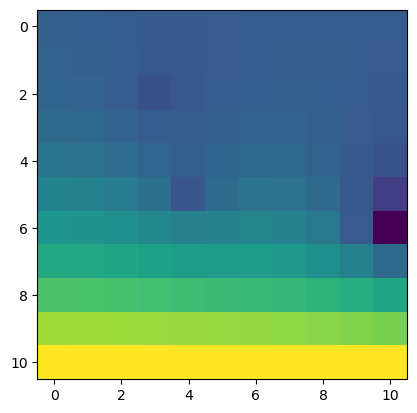

In [1]:
import os
import numpy as np
import pandas as pd
import flopy
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt

# filename
temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_name = "IdealModel1"
gwfname = "gwf_" + sim_name
gwtname = "gwt_" + sim_name

print(temp_dir.name)

# units
length_units = "meters"
time_units = "days"

# Discretization
nper = 1
nlay = 1
nrow = 11
ncol = 11
delr = 1000
delc = 1000
top = 30
botm = -10
idomain = 1

# GWF
icelltype = 1  # 潜水含水层

k11 = np.full([11, 11], 90)  # 渗透系数
k11[:4, :6] = 150
k11[8:, :] = 60
k11[5:8, 9:] = 60

# Temporal discretization
perlen = 1000.0
nstp = 1
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult))

# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

# Initial conditions
# Starting Heads
strt = np.full([11, 11], 30, dtype=float)

# Boundary conditions
# wel_spd

wel_spd = [[0, 2, 3, -1000], [0, 5, 4, -1500], [0, 6, 10, -2000]]
wel_spd = {0: wel_spd}

# chd_spd
chd_spd = []
for i in np.arange(ncol):
    chd_spd.append([0, 10, i, 30.0])

sim = flopy.mf6.MFSimulation(sim_name=sim_name, 
                             sim_ws='./IdealModel1', 
                             exe_name="mf6")

flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=gwfname,
    save_flows=True,
    model_nam_file="{}.nam".format(gwfname),
)

ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename="{}.ims".format(gwfname),
)
sim.register_ims_package(ims, [gwf.name])

flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename="{}.dis".format(gwfname),
)

flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=k11,
    k33=k11,
    save_specific_discharge=True,
    filename="{}.npf".format(gwfname),
)

flopy.mf6.ModflowGwfic(gwf, strt=strt, filename="{}.ic".format(gwfname))

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_spd),
    stress_period_data=chd_spd,
    save_flows=False,
    pname="CHD-1",
    filename="{}.chd".format(gwfname),
)

flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=wel_spd,
    save_flows=True,
    pname="WEL-1",
    filename="{}.wel".format(gwfname),
)

flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord="{}.hds".format(gwfname),
    budget_filerecord="{}.bud".format(gwfname),
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.write_simulation(silent=True)
success, buff = sim.run_simulation(silent=True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

head = gwf.oc.output.head().get_alldata()[0, 0]

plt.imshow(head)



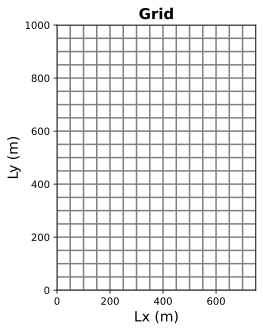

FloPy is using the following executable to run the model: ..\..\..\..\AppData\Local\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005Unsteadyflow.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/26 19:50:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    

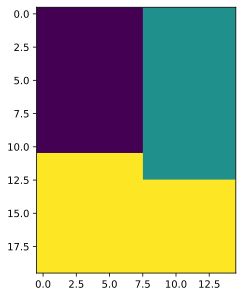

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import flopy
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name)
# MODFLOW
mymodel = flopy.modflow.Modflow('mf2005Unsteadyflow', exe_name="mf2005", model_ws = "./IdealModel2")
# DIS
#非稳定流的离散化仍然是使用 DIS。但与稳定流不同的是，本次离散化需要划分不同的应力周期和时间。
#以下是对空间上的划分
Lx = 750.0                               # x 长度
Ly = 1000.0                              # y 长度 
ztop = 5.0                               # z 顶部高程
zbot = -50.0                             # z 底部高程
nlay = 1                                 # 含水层层数
nrow = 20                                # 行数
ncol = 15                                # 列数
delc = Lx/ncol                           # x 步长
delr = Ly/nrow                           # y 步长
botm = np.linspace(ztop, zbot, nlay + 1) # z 每一层的底部高程 -50  
# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)创建等差数列
#start:返回样本数据开始点stop:返回样本数据结束点num:生成的样本数据量，默认为50

#以下是对时间上的划分
# nper 设为 3，意味着本次模拟共有 3 个应力周期。
# steady 是一个列表，列表内用布尔类型来表示每个应力周期内是否是稳定流，其中 True 为稳定流，False 为非稳定流。
# 第一个周期为稳定流，以便创建一个初始水头作为后续模拟的基础。
# perlen 也是一个列表，用于表示每个应力周期的长度。在稳定流周期中，长度可以任意值；在非稳定流中，不同的数值代表了不同的天数。本次均为 100 天。
# nstp 代表了每个应力周期的时间步长。可以理解为是时间上的分辨率。本次设为 100，即将 perlen 中一个应力周期的 100 天划分为 100 次。
nper = 3
steady = [True, False, False]
perlen = [1, 100, 100]
nstp = [1, 100, 100]

#将上述模型进行离散化 Discretization
dis = flopy.modflow.ModflowDis(mymodel, nlay, nrow, ncol, delr = delr,
                               delc = delc, top = ztop, botm = botm[1:], 
                               nper = nper, perlen = perlen, nstp = nstp, steady = steady)

############################################################################################################
#可以使用flopy自带的函数查看建模结果
modelmap = flopy.plot.PlotMapView(model = mymodel, layer = 0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)


strt = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)


bas = flopy.modflow.ModflowBas(mymodel, ibound=ibound, strt=strt)



# LPF Layer-Property Flow Package
# LPF 包与稳定流中的设置一致，直接定义含水层特性即可。


laytyp = 1  # 含水层类型


vka = 1.0  # 垂直渗透系数，单位：m/d


hk = np.ones((nlay, nrow, ncol), dtype=np.float32)  # 水平渗透系数，单位：m/d


hk[:, 0:11, 0:8] = 1.0


hk[:, 0:13, 8:16] = 3.0


hk[:, 11:21, 0:8] = 5.0


hk[:, 13:21, 8:16] = 5.0


sy = 0.1  # 给水度，单位：1/m


ss = 1.0e-4  # 单位储水量，单位：1/m


lpf = flopy.modflow.ModflowLpf(
    model=mymodel, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=1
)

# 检查水平渗透系数是否设置正确

plt.imshow(hk[0])

# 应力周期 0
shead_0 = 3
ehead_0 = 3
bound_sp_0 = []     
# 应力周期 1
shead_1 = 3
ehead_1 = 6
bound_sp_1 = []
# 应力周期 2
shead_2 = 6
ehead_2 = 1
bound_sp_2 = []
for lay in range(nlay):
    for col in range(ncol):
        bound_sp_0.append([lay, 0, col, shead_0, shead_0])
        bound_sp_1.append([lay, 0, col, shead_1, ehead_1])
        bound_sp_2.append([lay, 0, col, shead_2, ehead_2])

chd_spd = {0: bound_sp_0, 1: bound_sp_1, 2: bound_sp_2}
chd = flopy.modflow.ModflowChd(model= mymodel, stress_period_data = chd_spd)


# WEL 井的设置与边界类似，也是使用字典形式来储存。即一个键值对代表了该应力周期内井的位置和抽/补水效率。
wel_spd = {0: [[0, 3, 3, -500], [0, 5, 11, -100], [0, 18, 5,  600]],
           1: [[0, 3, 3, -200], [0, 5, 11,  200], [0, 18, 5, -350]],
           2: [[0, 3, 3, -100], [0, 5, 11,  500], [0, 18, 5,  100]]}
wel = flopy.modflow.ModflowWel(mymodel, stress_period_data = wel_spd)

k_rivbott = 1  # 河床底部渗透系数，m/d
thick_rivbott = 1  # 河床沉积物厚度，m
cond = k_rivbott * (delr) * (delc) / (thick_rivbott)  # conductance, m2/d
r_bott = 0  # 河底高程
riv_stage = [1, 5, 2]  # 河流水位
riv_sp_0 = []  # 应力周期 0
riv_sp_1 = []  # 应力周期 1
riv_sp_2 = []  # 应力周期 2
for i in range(ncol):
    riv_sp_0.append([0, 14, i, riv_stage[0], cond, r_bott])
    riv_sp_1.append([0, 14, i, riv_stage[1], cond, r_bott])
    riv_sp_2.append([0, 14, i, riv_stage[2], cond, r_bott])
riv_spd = {0: riv_sp_0, 1: riv_sp_1, 2: riv_sp_2}
riv = flopy.modflow.ModflowRiv(model=mymodel, stress_period_data=riv_spd)


# OC Output Control
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(
    mymodel, stress_period_data=stress_period_data, compact=True
)
# PCG
pcg = flopy.modflow.ModflowPcg(model=mymodel)
# RUN
mymodel.write_input()
success, mfoutput = mymodel.run_model(pause=False, report=True)
if not success:
    raise Exception("MODFLOW did not terminate normally.")

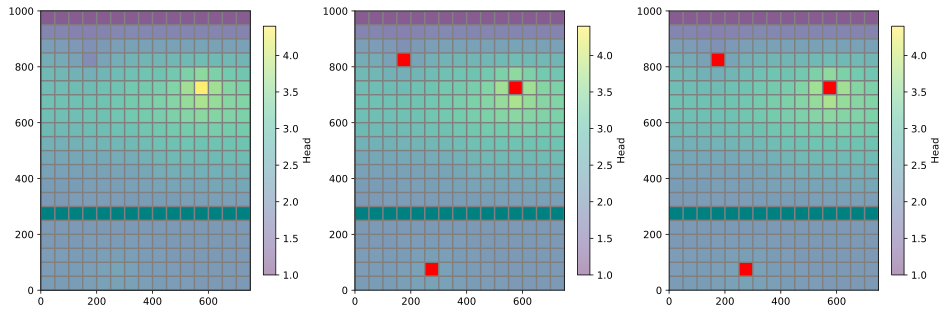

In [14]:
hf = flopy.utils.HeadFile("./IdealModel2" + "/mf2005Unsteadyflow.hds")
hds = hf.get_data()

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 3, 1, aspect="equal")
mv = flopy.plot.PlotMapView(model=mymodel,layer=0)
mv.plot_grid()
mv.plot_ibound()
hd = mv.plot_array(hds, alpha=0.4)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_bc("RIV",kper=0)
mv.plot_bc("WEL", plotAll=True)
# mv.plot_pathline(pl, layer="all", alpha=0.5, colors=["purple"], lw=2)

ax = fig.add_subplot(1, 3, 2, aspect="equal")
mv = flopy.plot.PlotMapView(model=mymodel,)
mv.plot_grid()
mv.plot_ibound()
hd = mv.plot_array(hds, alpha=0.4)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_bc("RIV",kper=1)
mv.plot_bc("WEL", plotAll=True)

ax = fig.add_subplot(1, 3, 3, aspect="equal")
mv = flopy.plot.PlotMapView(model=mymodel,)
mv.plot_grid()
#mv.plot_ibound()
hd = mv.plot_array(hds, alpha=0.4)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_bc("RIV",kper=2)
mv.plot_bc("WEL", plotAll=True)
plt.show()

c:\Environment\MiniConda\envs\backend\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


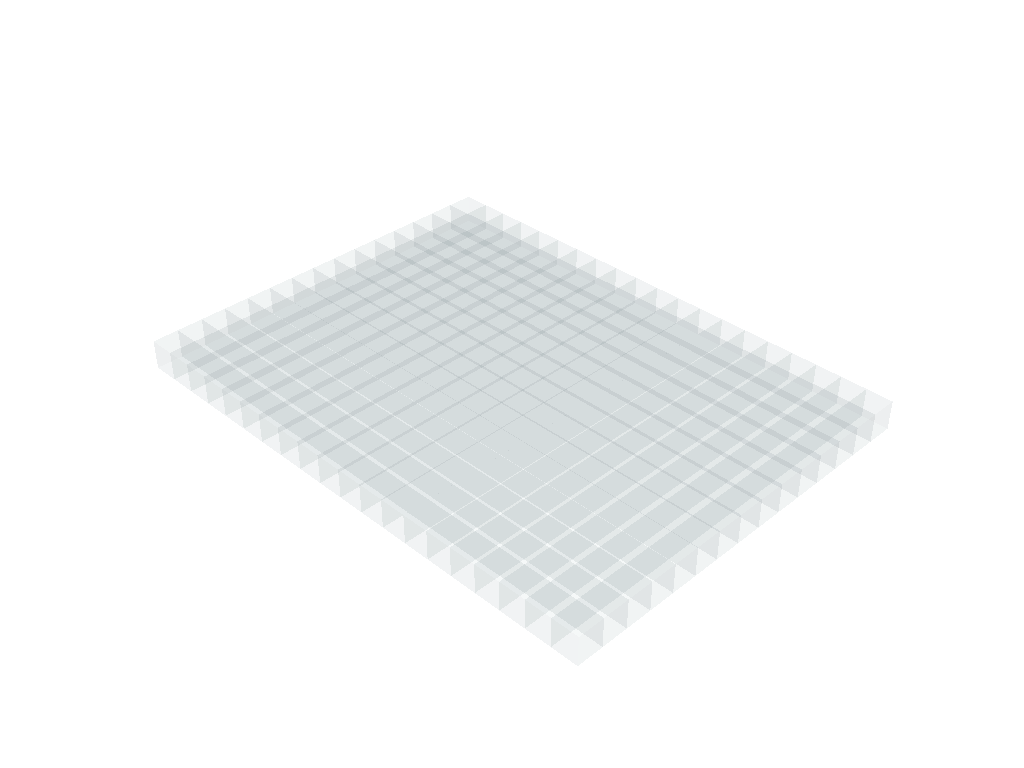

In [18]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=mymodel, binary=False, 
          #vertical_exageration=50, 
          smooth=False)
vtk.add_model(mymodel)

grid= vtk.to_pyvista()

import pyvista as pv

axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

#grid.rotate_z(160, point=axes.origin, inplace=True)
# pathlines.rotate_z(160, point=axes.origin, inplace=True)

p = pv.Plotter()
p.add_mesh(grid, opacity=0.05)

#p.camera.zoom(2.4)
p.show()

In [3]:
# head = flopy.utils.binaryfile.HeadFile(temp_dir.name + "\\"+ gwfname + ".hed")
# budg = flopy.utils.binaryfile.CellBudgetFile(temp_dir.name + "\\" + gwfname + ".ccf")
head = flopy.utils.binaryfile.HeadFile("./IdealModel2" + "/mf2005Unsteadyflow.hds")
budg = flopy.utils.binaryfile.CellBudgetFile(
    "./IdealModel2" + "/mf2005Unsteadyflow.cbc"
)

In [4]:
vtk1 = flopy.export.vtk.Vtk(mymodel)  # 创建 vtk 文件
vtk1.add_heads(hds=head)  # 添加水头结果
vtk1.add_cell_budget(cbc=budg)  # 添加流量结果
# 添加各类静态数据
vtk1.add_package(pkg=bas)
vtk1.add_package(pkg=lpf)
vtk1.add_package(pkg=dis)

vtk2 = flopy.export.vtk.Vtk(mymodel)
# 添加各类瞬态数据
vtk2.add_package(pkg=riv)
vtk2.add_package(pkg=wel)

# 导出结果
vtk1.write("./VTKs/vtk1.vtk")
vtk2.write("./VTKs/vtk2.vtk")